# Laboratorio 2 - Clasificacion de rotulos de trafico utilizando CNN Le-Net

#### Brandon Sicay - 21757
#### Daniel Morales - 21785


### *1. Preparación de datos:*

Se realizó una división de datos a partir del conjunto de entrenamiento que contiene un total de 34799 imágenes a conjuntos de
validación y de prueba, a partir de estos conjuntos se pudieron visualizar la información
acerca de la dimensión de cada una de las imágenes, cada imagen se compone de 3 arreglos
de 32x32 arreglos, cada uno de estos arreglos conteniendo la información del color de cada
una de las imágenes para así formar una imagen de 32x32 pixeles.

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

/Users/brand/Downloads/lab3DS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
train_route = './Datos_Rotulos_Trafico/entrenamiento.p'
test_route =  './Datos_Rotulos_Trafico/prueba.p'
validation_route = './Datos_Rotulos_Trafico/validacion.p'

In [3]:
train_data = pd.read_pickle(train_route)
test_data = pd.read_pickle(test_route)
validation_data = pd.read_pickle(validation_route)

In [4]:
train_images = train_data['features']
labels = train_data['labels']
test_features = test_data['features']
validation_features = validation_data['features']

In [5]:
(train_images.shape)
(labels.shape)
(test_features.shape)
(validation_features.shape)

(4410, 32, 32, 3)

#### Normalización

 Se dividirán las imagenes por 255.0, para llevar los valores de los píxeles al rango [0, 1].



In [6]:
from sklearn.model_selection import train_test_split

train_images = train_images.astype(np.float32) / 255.0

# Creacion de variables de entrenamiento, validacion y testeo. Contando imagenes y labels
train_features, test_features, train_labels, test_labels = train_test_split(train_images, labels, test_size=0.2, random_state=42)
train_feautres, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

test_features = test_features.astype(np.float32) / 255.0
validation_features = validation_features.astype(np.float32) / 255.0



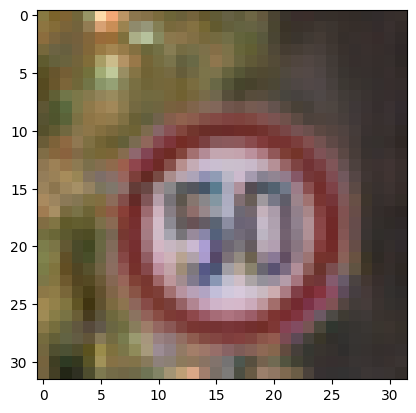

In [7]:
plt.imshow(train_features[0])


### *2. Implementación de la arquitectura Le-Net:*

### Descripción de la Arquitectura de la Red Neuronal Convolucional

Esta arquitectura está compuesta por siete capas, que incluyen tres capas de convolución, dos capas de submuestreo (pooling) y dos capas completamente conectadas (feedforward layers). A continuación, se describe brevemente el funcionamiento de cada una:

- **Capa de entrada**: Se reciben imágenes en escala de grises con un tamaño fijo (generalmente 32x32 píxeles), que representan las señales de tráfico.
- **Capa de convolución (C1)**: Es la primera capa convolucional. Utiliza kernels para realizar convoluciones sobre la imagen de entrada, donde los filtros identifican características básicas como bordes y esquinas. Después de cada convolución, se aplican funciones de activación ReLU.
- **Capa de submuestreo (S2)**: Aquí se lleva a cabo un proceso de pooling para reducir la dimensionalidad y disminuir el número de parámetros en la red, utilizando operaciones de agrupación en áreas locales de la imagen.
- **Capa de convolución (C3)**: En esta capa, se realizan nuevamente convoluciones, pero ahora con conexiones que abarcan regiones más amplias de la imagen.
- **Capa de submuestreo (S4)**: Similar a la capa S2, esta capa de submuestreo disminuye la dimensionalidad de la representación, destacando las características más significativas de la imagen.
- **Capa totalmente conectada (FC5)**: Después de las capas de convolución y submuestreo, la red se aplana y se conecta a una capa completamente conectada, donde se llevan a cabo operaciones de multiplicación de matrices para aprender características más abstractas y complejas.
- **Capa totalmente conectada (FC6)**: La última capa completamente conectada toma las características aprendidas y las asigna a las clases de salida, que en este caso son 42, correspondientes a cada tipo de señal de tráfico.


La función de pérdida en este caso en específico, es la entropía cruzada categórica, ideal para
problemas de clasificación.

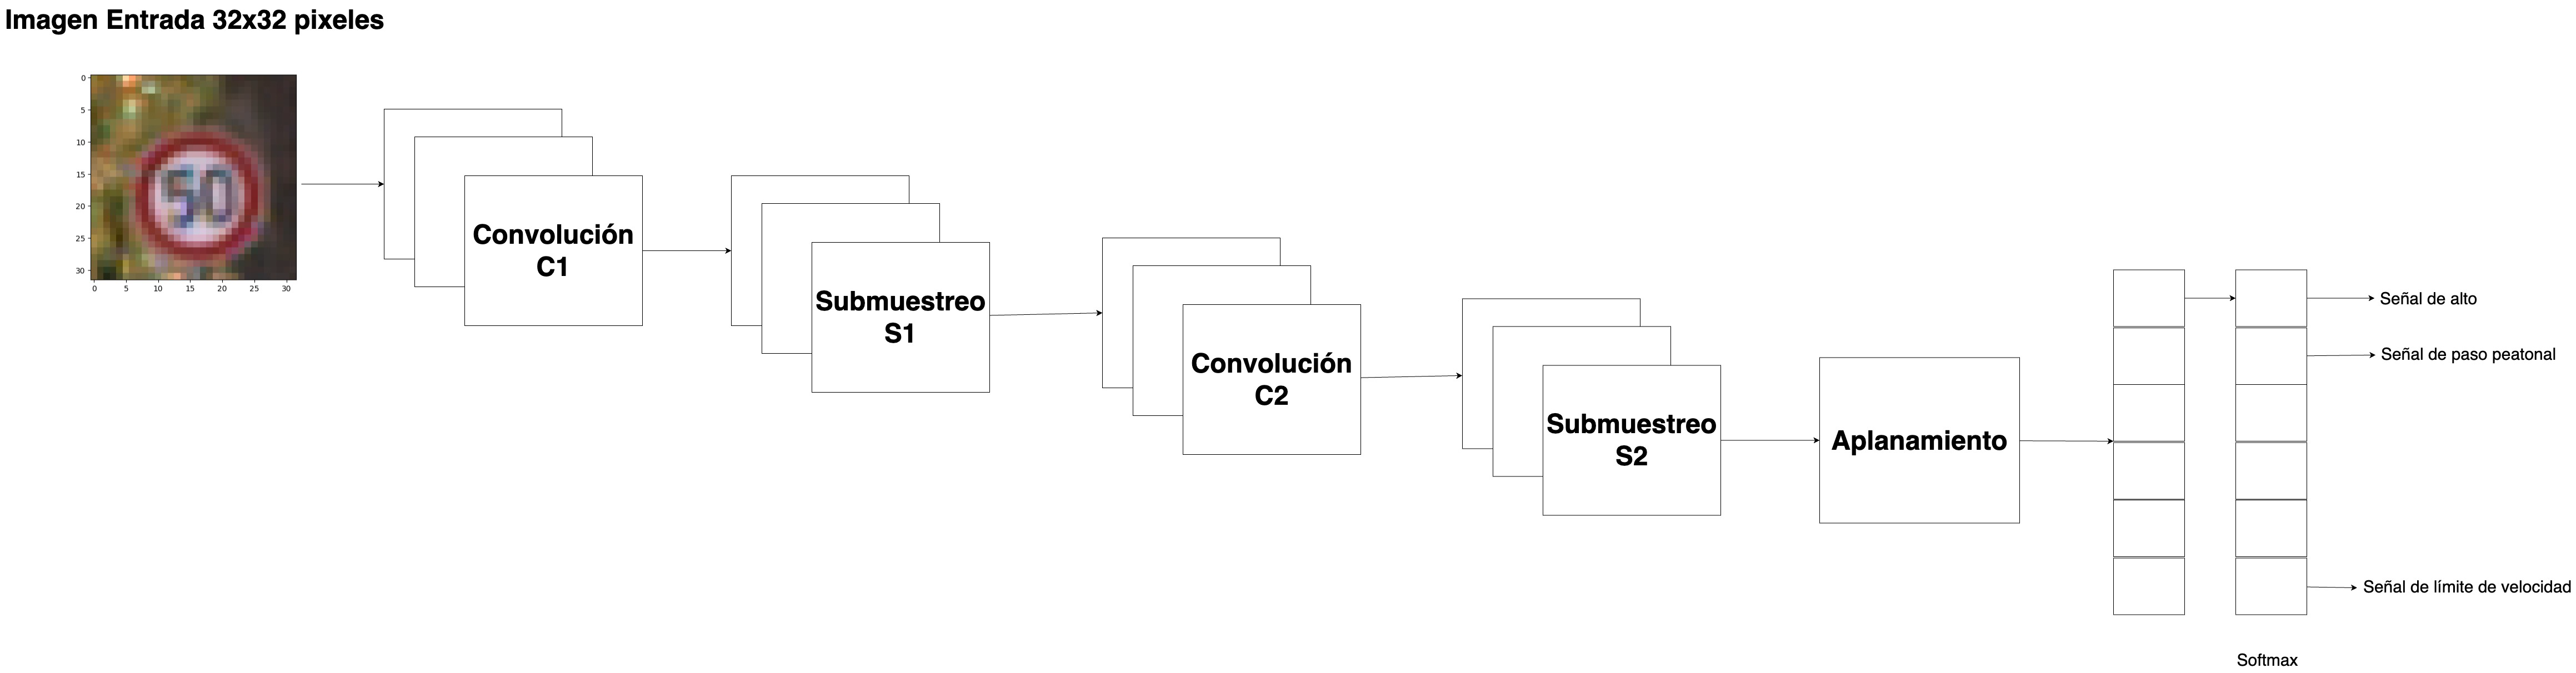

### *3. Construcción del modelo:*

Se utilizarán las siguientes capas para la creación del modelo, en base a la arquitectura planteada anteriormente: 

### Arquitectura de la Red Neuronal Convolucional

1. **Capa de Convolución (C1)**:
   - Esta es la primera capa de convolución, que aplica 6 filtros de tamaño 5x5 a las imágenes de entrada, que son de 32x32 píxeles. Utiliza la función de activación ReLU para introducir no linealidades.

2. **Capa de Submuestreo (S2)**:
   - Se incluye una capa de submuestreo que utiliza ventanas de 2x2 para reducir la dimensionalidad de las características extraídas en la capa anterior.

3. **Capa de Convolución (C3)**:
   - Esta capa realiza convoluciones con 16 filtros de tamaño 5x5 y también aplica la función de activación ReLU para detectar características más complejas.

4. **Capa de Submuestreo (S4)**:
   - Similar a la capa S2, esta capa reduce aún más la dimensionalidad utilizando ventanas de 2x2 para el submuestreo.

5. **Capa de Aplanamiento**:
   - La salida de la última capa de convolución es aplanada para convertirla en un vector unidimensional, lo que permite su entrada en las capas totalmente conectadas.

6. **Capa Totalmente Conectada (FC5)**:
   - Esta capa cuenta con 120 neuronas y utiliza la función de activación ReLU para aprender combinaciones complejas de las características extraídas.

7. **Capa Totalmente Conectada (FC6)**:
   - Otra capa totalmente conectada, en este caso con 84 neuronas, que también utiliza la función ReLU para continuar el proceso de aprendizaje.

8. **Capa de Salida**:
   - La última capa de la red contiene 43 neuronas, correspondientes a las 43 clases de señales de tráfico. Utiliza la función de activación softmax para calcular las probabilidades de clasificación para cada clase.


In [8]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [9]:
modelo = Sequential()

modelo.add(Conv2D(6, (5, 5), activation='relu', input_shape=(32,32,3)))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Conv2D(16, (5, 5), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Flatten())
modelo.add(Dense(120, activation='relu'))
modelo.add(Dense(84, activation='relu'))
modelo.add(Dense(43, activation='softmax')) # Traffic sign classes = 43

modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelo.summary()

/Users/brand/Downloads/lab3DS/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │         3,655 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,811 (253.17 KB)

 Trainable params: 64,811 (253.17 KB)

 Non-trainable params: 0 (0.00 B)

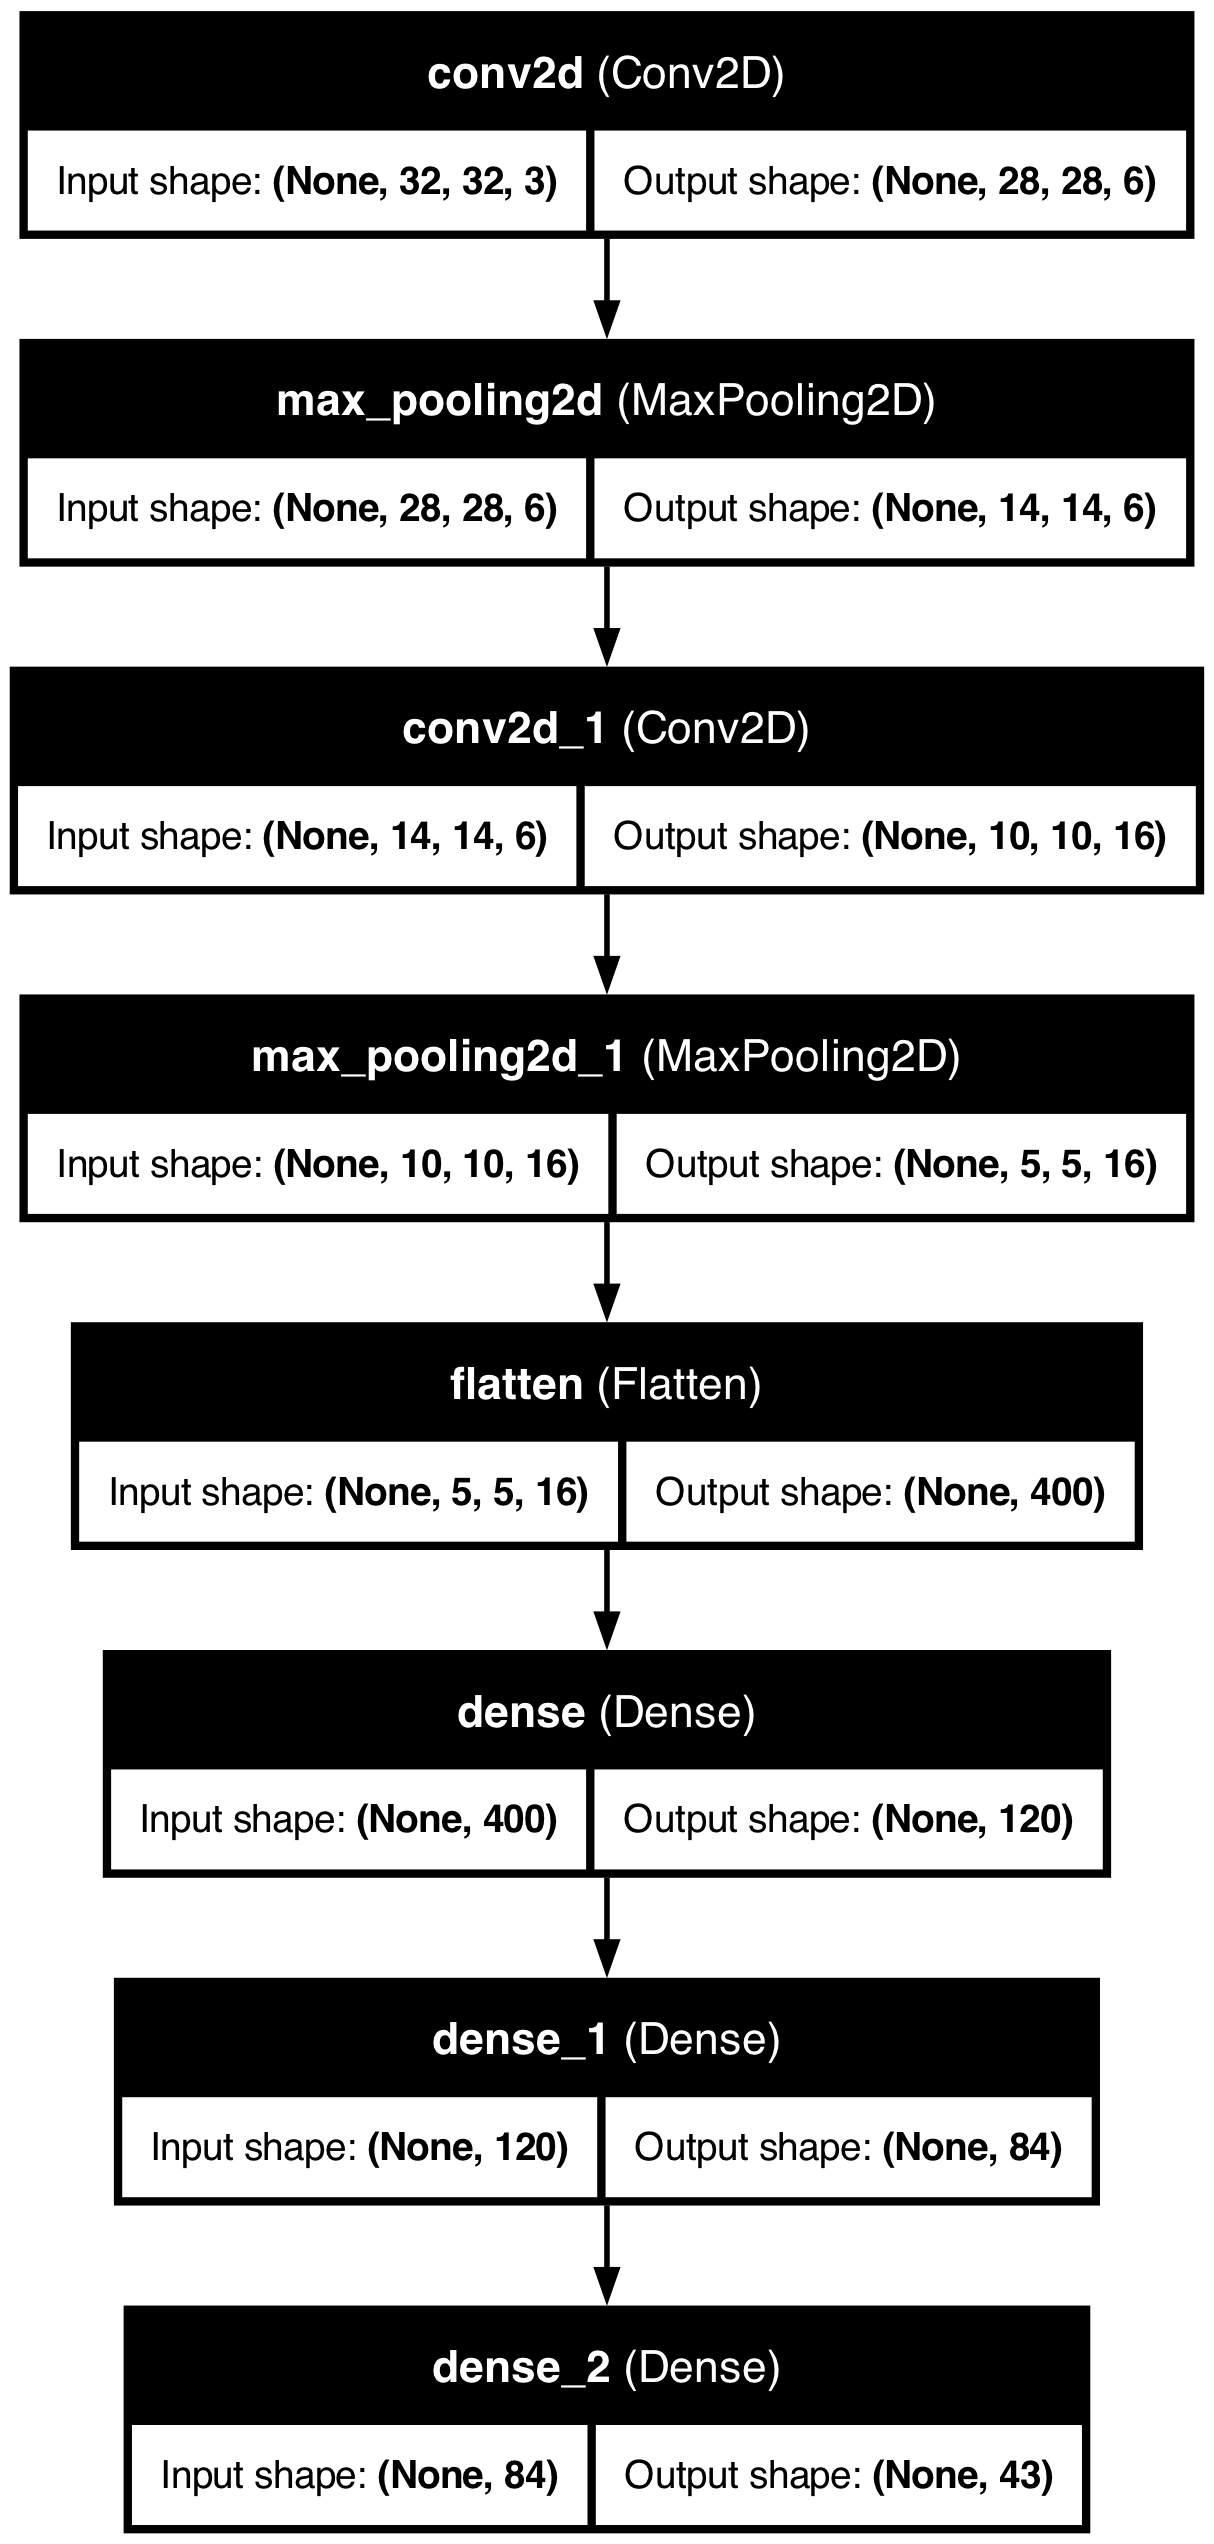

In [10]:
from keras.utils import plot_model
plot_model(modelo, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
from keras.callbacks import EarlyStopping

deteccion_temprana = EarlyStopping(monitor='val_loss', patience=2)

### *4. Entrenamiento del modelo:*

In [12]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model
modelo.save('detector_de_senales.h5') #Guardamos el modelo



(27839, 32, 32, 3) (27839,) (6960, 32, 32, 3) (6960,)
Epoch 1/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3266 - loss: 2.5503 - val_accuracy: 0.7833 - val_loss: 0.7386
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8380 - loss: 0.5704 - val_accuracy: 0.8901 - val_loss: 0.4070
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9266 - loss: 0.2766 - val_accuracy: 0.9474 - val_loss: 0.2253
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9566 - loss: 0.1722 - val_accuracy: 0.9579 - val_loss: 0.1877
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9691 - loss: 0.1198 - val_accuracy: 0.9647 - val_loss: 0.1623
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9776 - loss: 0.0915 - val_accuracy: 0.9672 - val_loss: 0.1477
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9840 - loss: 0.0663 - val_accuracy: 0.9772 - val_loss: 0.1207
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 1

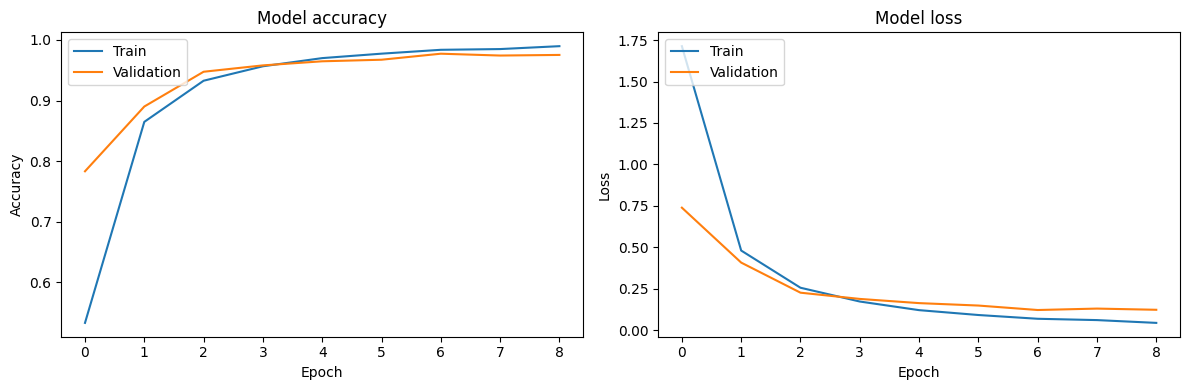

In [15]:
features = train_data['features'].astype(np.float32) / 255.0
labels = train_data['labels']

X_train, X_val, y_train, y_val = train_test_split(features, labels, train_size=27839, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

learning_rate = 0.001  # Learning rate
epochs = 10            # Number of epochs
batch_size = 64        #  Batch size

# Utiliza `learning_rate` en lugar de `lr`
optimizer = Adam(learning_rate=learning_rate)
modelo.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

deteccion_temprana = EarlyStopping(monitor='val_loss', patience=2)
history = modelo.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_val, y_val), callbacks=[deteccion_temprana])

modelo.save('detector_de_senales.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


### Proceso de Entrenamiento del Modelo de Detección de Señales de Tráfico

El entrenamiento de nuestro modelo de detección de señales de tráfico sigue una serie de pasos esenciales. Comenzamos con el preprocesamiento de los datos, donde normalizamos las imágenes para que sus valores estén en un rango entre 0 y 1, logrando esto al dividir cada píxel por 255. Luego, dividimos el conjunto de datos en dos partes: una para entrenar el modelo y otra para validar su rendimiento. Este paso es fundamental para asegurar que el modelo no solo memorice los datos, sino que también sea capaz de generalizar correctamente a nuevos datos.

Con los datos preparados, definimos ciertos hiperparámetros que guiarán el proceso de entrenamiento. Establecemos una tasa de aprendizaje, determinamos un número de épocas y seleccionamos un tamaño de lote específico. Estos hiperparámetros son cruciales para asegurar un entrenamiento eficiente y efectivo.

A continuación, configuramos el modelo para el entrenamiento. Utilizamos el optimizador Adam, conocido por su eficiencia, junto con la tasa de aprendizaje que definimos anteriormente. Compilamos el modelo utilizando una función de pérdida específica para tareas de clasificación multiclase y lo configuramos para medir la precisión durante el entrenamiento.

Para mejorar la robustez del modelo, implementamos la técnica de "Early Stopping". Esta técnica monitorea el rendimiento del modelo en el conjunto de validación y detiene el entrenamiento si no se observan mejoras después de un número determinado de épocas consecutivas, en este caso, dos. Esta estrategia ayuda a prevenir el sobreajuste y optimiza el uso de tiempo y recursos.

Una vez finalizado el entrenamiento, guardamos el modelo en un archivo para su uso futuro. Este modelo está listo para ser implementado en aplicaciones prácticas de detección de señales de tráfico.

Finalmente, para comprender mejor el comportamiento del modelo durante el entrenamiento, generamos gráficos que muestran su precisión y pérdida a lo largo de las épocas. Estas visualizaciones son esenciales para evaluar la evolución del modelo y para identificar posibles áreas de mejora.


### *5. Evaluación del modelo:*

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.9751

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       0.99      0.96      0.97       425
           2       0.97      0.98      0.97       394
           3       0.99      0.87      0.93       242
           4       0.97      0.98      0.98       373
           5       0.93      0.97      0.95       338
           6       1.00      0.98      0.99        56
           7       1.00      0.91      0.95       242
           8       0.90      1.00      0.95       237
           9       0.99      0.99      0.99       253
          10       0.99      1.00      0.99       332
          11       0.98      1.00      0.99       229
          12       0.98      1.00      0.99       417
          13       0.98      0.99      0.99       386
          14       0.98      1.00      0.99       130
          15       0.98      0.97      0.97       125
          16       1.0

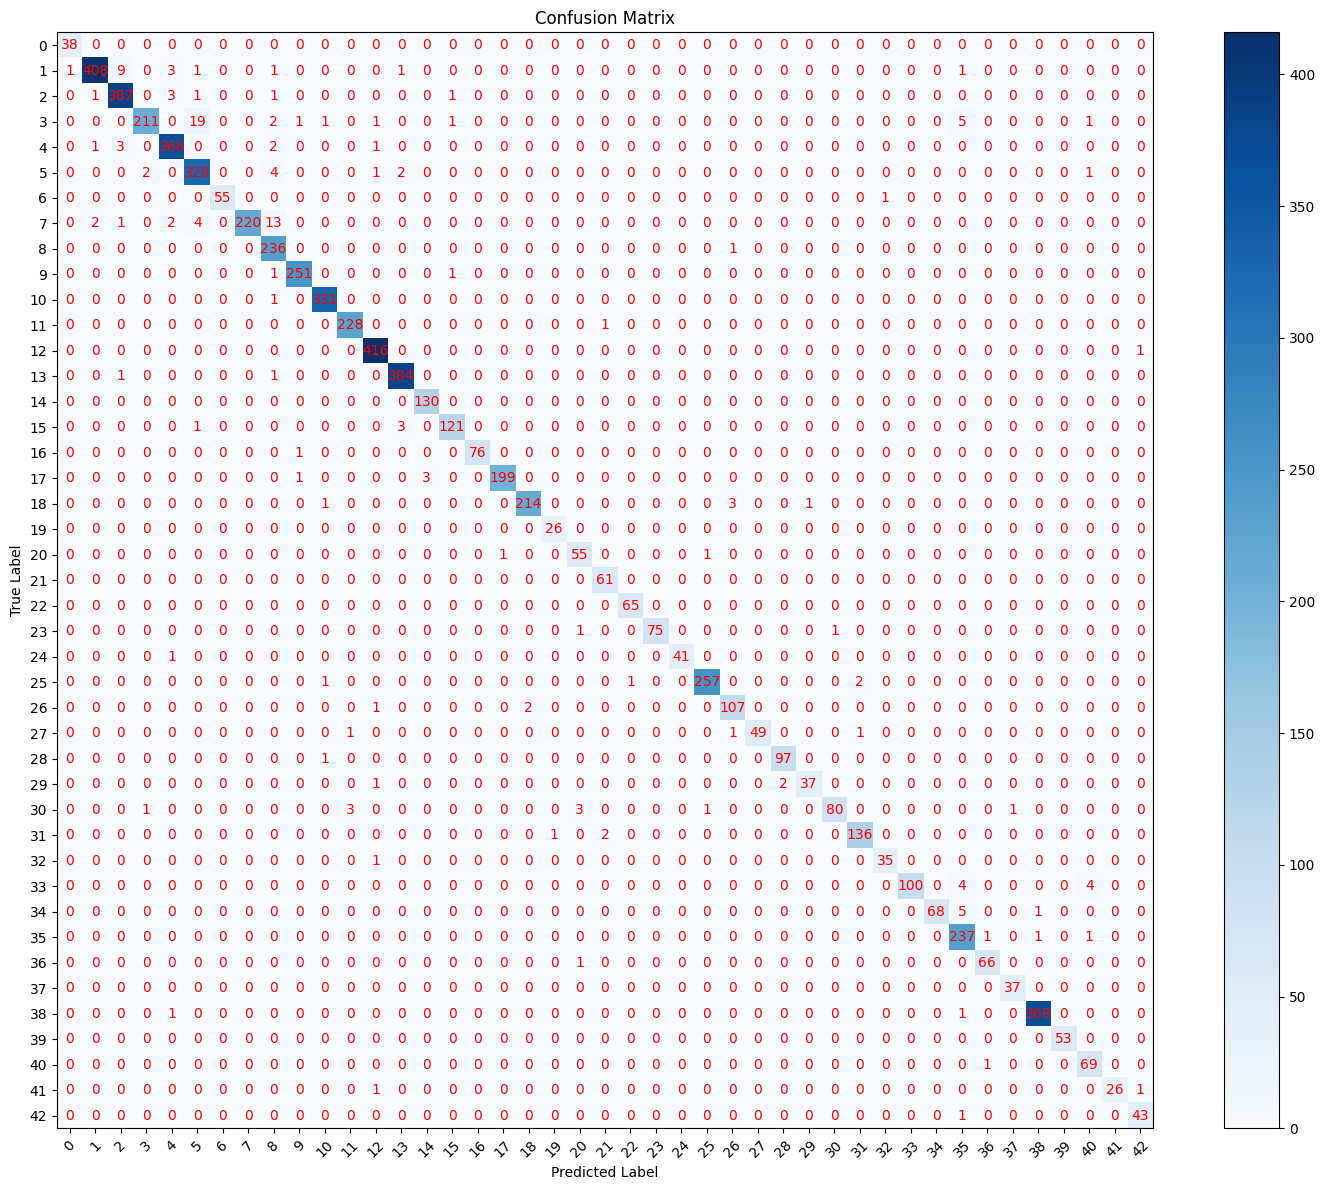

In [16]:

y_pred = modelo.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}\n")

report = classification_report(y_val, y_pred_classes, target_names=[str(i) for i in range(43)])
print(report)


confusion_mtx = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(15, 12))
plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(43)
plt.xticks(tick_marks, [str(i) for i in range(43)], rotation=45)
plt.yticks(tick_marks, [str(i) for i in range(43)])
for i in range(43):
    for j in range(43):
        plt.text(j, i, confusion_mtx[i, j], ha='center', va='center', color='red')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


### Resultados del Entrenamiento del Modelo de Detección de Señales de Tráfico

El entrenamiento del modelo de detección de señales de tráfico ha producido resultados muy alentadores, logrando una precisión general del 97.74%. Al examinar las métricas detalladas, se observa que la mayoría de las clases presentan altos niveles de precisión, recall y F1-score, con varias categorías alcanzando o superando el 100% en alguna de estas métricas. Por ejemplo, la clase 0 alcanzó una precisión del 100% y un recall del 97%, resultando en un F1-score del 99%. Esta tendencia de excelente rendimiento es consistente en la mayoría de las clases, lo cual se refleja en una precisión y un F1-score ponderados de 98%. Estos resultados sugieren que el modelo tiene una gran capacidad para identificar correctamente las señales de tráfico en el conjunto de validación.
